In [8]:
import numpy as np

probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0

# 기댓값(가중 평균) 계산을 반복문으로 구현
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]
print(expected_value)

# 두 벡터에 대한 내적 즉, 행렬곱을 수행하면 반복문을 수행하지 않고 기댓값(가중 평균) 계산을 수행할 수 있다
expected_value = probs @ outcomes
print(expected_value)

T = lambda: expected_value + np.random.randn(1)
T()

18.4
18.4


array([19.13162764])

[0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]


<BarContainer object of 51 artists>

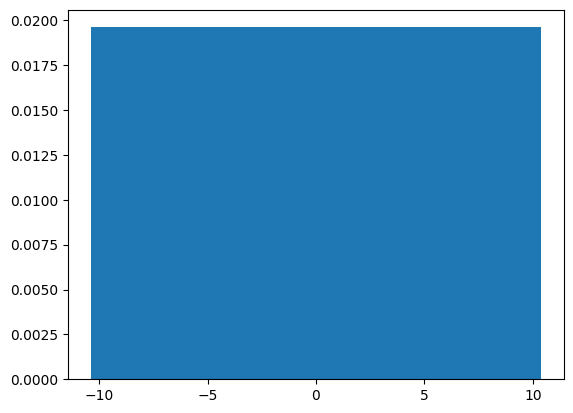

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

vmin, vmax = -10., 10. # 행동 가치 분포에 대한 지지집합(support)의 최대와 최소
nsup = 51 # 지지집합의 크기(지지집합 내 원소의 개수)
support = np.linspace(vmin, vmax, nsup) # [-10.0, 10.0]구간 상에서 균일하게 형성된(퍼진) 표본들(여기서는 지지집합의 원소이자 행동 가치 분포의 확률 변수 값)이 반환된다
probs = np.ones(nsup)
probs /= probs.sum() # 지지집합에 대응하는 확률을 균일하게 하여, 행동 가치 분포를 균일 분포로 초기화한다
z3 = torch.from_numpy(probs).float() # 에이전트의 행동 공간(action space) 크기가 3(즉, 에이전트가 취할 수 있는 행동이 3개이다)이므로, 3개의 행동 가치 분포가 산출된다

print(probs)
plt.bar(support, probs) # bottom 옵션은 막대 그래프 높이의 기준점을 설정한다(bottom=1이라면 높이 1부터 막대 그래프가 그려진다)

In [ ]:
# lim = limit, 행동가치분포 확률 변수 값(지지집합)의 범위를 지정한다
def update_dist(r, probs, lim=(-10.0, 10.0), gamma=0.8):
    '''
    update_dist 함수는 모델이 산출한 예측분포(행동가치분포)에 대한 목표분포(행동가치분포)를 구한다
    본래 논문대로 구현한다면 분포 벨먼 방정식에 따라 목표분포를 구하지만, 책에서는 베이지안 방식으로 목표분포를 구한다
    즉, 예측분포와 목표분포를 각각 사전분포와 사후분포로 간주하여, 예측분포(사전분포)를 주어진 보상을 통해 목표분포(사후분포)로 갱신한다
    주어진 보상으로 사전분포를 사후분포로 갱신하는 방법은 아래와 같다
    1. 보상이 주어지면, 지지집합의 내에서 그 보상과 가장 가까운 원소(행동가치)를 찾는다(이를 위해 지지집합의 최소인 vmin으로부터 r까지의 차이를 계산한다)
    2. 1.에서 발견된 원소를 시작으로 옆의 원소로부터 확률의 일부를 떼어온다(이 과정은 1.에서 발견된 원소를 기준으로 좌측과 우측 방향에 대해 수행된다)
    '''
    
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.0) # dz = delta z, 지지집합 내 원소간 간격
                                      # 지지집합의 크기는 vmax와 vmin을 포함하여 51이고, 그 사이의 간격은 50개이다
                                      # 따라서 dz를 계산할 때는 nsup에 -1을 해주어야 한다
    bj = np.round((r - vmin) / dz) # 주어진 보상 r이 지지집합 내 원소 중 어떤 것과 가장 가까운지 계산한다
    bj = int(np.clip(bj, 0, nsup - 1)) # [0, 50]에 대하여 bj가 0보다 작으면 0으로, 50보다 크면 50으로 설정한다(이 때의 닫힌 구간은 지지집합 내 원소들에 대응하는 인덱스이다)
    m = probs.clone() # probs는 예측분포에 대한 확률 벡터이고, 이를 통해 별도의 목표분포애 대한 확률 벡터를 구하는 것이 목적이므로 clone을 통한 "깊은 복사"를 수행한다

    # 보상에 가장 가까운 지지집합 원소를 시작으로 왼쪽 원소들의 확률 일부를 떼어온다
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1

    # 보상에 가장 가까운 지지집합 원소를 시작으로 오른쪽 원소들의 확률 일부를 떼어온다
    j = 1
    for i in range(bj, nsup - 1, 1):
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m /= m.sum()

    return m